# Recurrent Vision Project (VS265, Fall 2022)

#### Team Members: Shafeeq Ibraheem, Hansen Lillemark, Jacob Yeung

#### This notebook is a basic CNN model which will train on the MNIST dataset. We will then compare its test accuracy on the MNIST test set and a noisy version of the MNIST test set. 
#### We are expecting the model to perform worse on the noisy test set, as the model has not been trained on noisy data.

In [93]:
# Import libraries for convolutional neural network and data processing
# We will use pytorch to create a convolutional neural network training on MNIST dataset. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Import the MNIST dataset
from torchvision import datasets, transforms

# set seed
torch.manual_seed(101)
np.random.seed(42)

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [75]:
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transforms.ToTensor())
print(train_data)
print(train_data.data.size())
print(test_data)
print(test_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([10000, 28, 28])


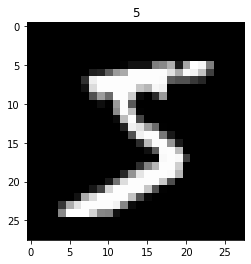

In [76]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

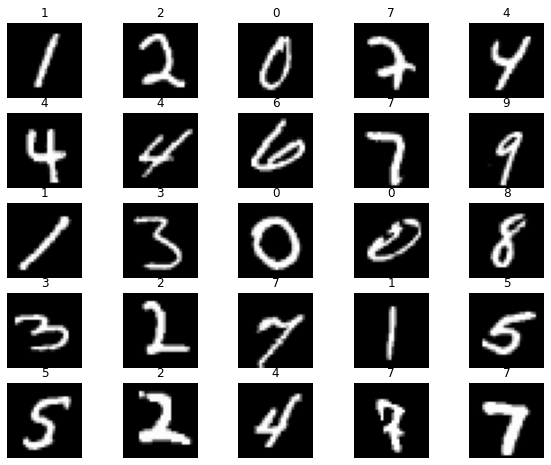

In [77]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [78]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fd34836ceb0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fd311f1ff40>}

In [79]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [80]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [81]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [82]:
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [83]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.0663
Epoch [1/10], Step [200/600], Loss: 0.1444
Epoch [1/10], Step [300/600], Loss: 0.0774
Epoch [1/10], Step [400/600], Loss: 0.0898
Epoch [1/10], Step [500/600], Loss: 0.1545
Epoch [1/10], Step [600/600], Loss: 0.0520
Epoch [2/10], Step [100/600], Loss: 0.0554
Epoch [2/10], Step [200/600], Loss: 0.1017
Epoch [2/10], Step [300/600], Loss: 0.0986
Epoch [2/10], Step [400/600], Loss: 0.0704
Epoch [2/10], Step [500/600], Loss: 0.0046
Epoch [2/10], Step [600/600], Loss: 0.0269
Epoch [3/10], Step [100/600], Loss: 0.0077
Epoch [3/10], Step [200/600], Loss: 0.0039
Epoch [3/10], Step [300/600], Loss: 0.0485
Epoch [3/10], Step [400/600], Loss: 0.0692
Epoch [3/10], Step [500/600], Loss: 0.0594
Epoch [3/10], Step [600/600], Loss: 0.1012
Epoch [4/10], Step [100/600], Loss: 0.0362
Epoch [4/10], Step [200/600], Loss: 0.0206
Epoch [4/10], Step [300/600], Loss: 0.0066
Epoch [4/10], Step [400/600], Loss: 0.0821
Epoch [4/10], Step [500/600], Loss: 0.1070
Epoch [4/10

In [84]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            pass
        accuracy = correct / 10000 
        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.9835


In [85]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [86]:
actual_number = lbls[:10].numpy()
actual_number

array([8, 9, 8, 8, 1, 1, 5, 5, 3, 7])

In [87]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [8 9 8 8 1 1 5 5 3 7]
Actual number: [8 9 8 8 1 1 5 5 3 7]


In [88]:
# Now we will add some gaussian noise to the test data and see if the performance is still good with the model which is not trained on noisy data.
# We will use the same model which we trained on clean data.

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

test_data_noisy = datasets.MNIST(root = 'data', train = False, download = True, 
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
]))


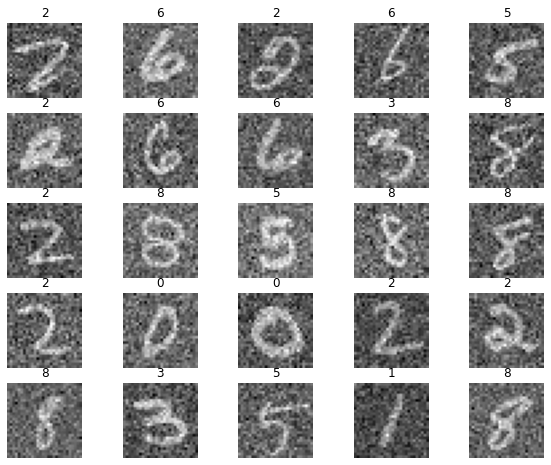

In [89]:
# View some of the noisy data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data_noisy), size=(1,)).item()
    img, label = test_data_noisy[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [90]:
loaders['test_data_noisy'] = torch.utils.data.DataLoader(test_data_noisy, 
                                          batch_size=100, 
                                          shuffle=True)
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fd34836ceb0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fd311f1ff40>,
 'test_data_noisy': <torch.utils.data.dataloader.DataLoader at 0x7fd370ad0430>}

In [91]:
def test_noisy():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        for images, labels in loaders['test_data_noisy']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
            pass
        accuracy = correct / 10000 
        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)
    
    pass
test_noisy()

Test Accuracy of the model on the 10000 test images: 0.1632


In [71]:
# Apart from the gaussion noise experiment, we will also add a mask to the image to see if the model can still perform well on the masked numbers. 

class AddMask(object):
    def __init__(self, mask_size=0.5):
        self.mask_size = mask_size
        
    def __call__(self, tensor):
        mask = torch.ones(tensor.size())
        mask[:, :, int(tensor.size(2) * self.mask_size):, :] = 0
        return tensor * mask
    
    def __repr__(self):
        return self.__class__.__name__ + '(mask_size={0})'.format(self.mask_size)

test_data_masked = datasets.MNIST(root = 'data', train = False, download = True,

    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # AddMask(0.5)
]))


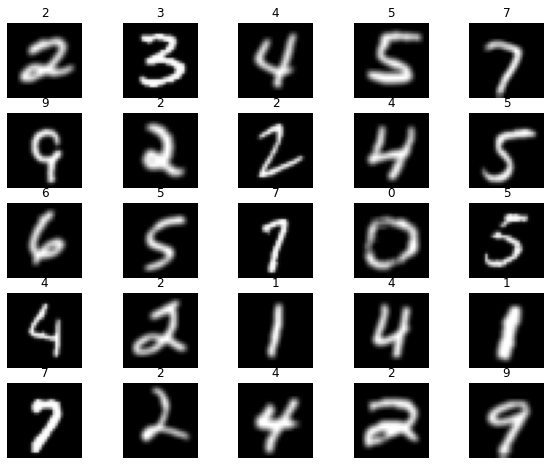

In [72]:
# View some of the masked data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data_masked), size=(1,)).item()
    img, label = test_data_masked[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()